### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor, BayesRidgeRegressorExt)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# setting to make life easier
Temperature='MeanTemp'
kmeans0='TemperatureKmeansScore0'
kmeans='TemperatureKmeansScore'
fft0='FFTAnomalyScore0'
fft='FFTAnomalyScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansA0='kmeansAnomaly0'
spectralA='spectralAnomaly'
fftA0='fftAnomaly0'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [3]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2021-04-22T19:46:08.009 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 


In [4]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./Weather.csv', 
                   dtype={"Snowfall":object, "PoorWeather":object, "SNF": object, "TSHDSBRSGF":object},
                   index_col=False, parse_dates=['Date'])

df_i.rename(columns={'Date': 'timestamp'}, inplace=True)

# drastic filtering
df_i = df_i[df_i['STA'] == 10001]

df_i['entity'] = df_i['STA'].astype(str)



# and sort it by timestamp
df_i = df_i[['entity','timestamp','Precip','MaxTemp','MinTemp','MeanTemp']].sort_values(by=['entity','timestamp'])


df_i = df_i.set_index(['entity','timestamp']).dropna()


df_i.head(8)


2021-04-22T19:46:16.574 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-04-22T19:46:16.575 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


Precip    MaxTemp    MinTemp   MeanTemp
entity timestamp                                         
10001  1942-07-01  1.016  25.555556  22.222222  23.888889
       1942-07-02      0  28.888889  21.666667  25.555556
       1942-07-03   2.54  26.111111  22.222222  24.444444
       1942-07-04   2.54  26.666667  22.222222  24.444444
       1942-07-05      0  26.666667  21.666667  24.444444
       1942-07-06      0  26.666667  21.666667  24.444444
       1942-07-07      T  28.333333  22.777778  25.555556
       1942-07-08  3.556  26.666667  22.222222  24.444444

In [9]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = BayesRidgeRegressor(['MinTemp'], ['MaxTemp'])
et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)


df_i.describe()

2021-04-22T19:47:20.655 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-04-22T19:47:20.658 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-04-22T19:47:20.660 DEBUG iotfunctions.util.__init__ Starting trace
2021-04-22T19:47:20.661 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_BayesRidgeRegressor_20210422174720
2021-04-22T19:47:20.662 DEBUG iotfunctions.util.__init__ auto_save None
2021-04-22T19:47:20.663 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-04-22T19:47:20.664 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-04-22T19:47:20.666 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_BAYESRIDGEREGRESSOR
Functions:
Granularities:
No schedules metadata
2021-04-22T19:47:20.667 

/home/markus/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,MaxTemp,MinTemp,MeanTemp,predicted_MaxTemp,stddev_MaxTemp
count,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000
mean,30.496975,22.520407,26.514933,30.496958,2.056946
std,2.509494,1.426508,1.777196,1.500411,0.001814
min,21.111111,16.111111,20.555556,23.755617,2.055860
25%,28.333333,21.666667,25.000000,29.598988,2.055865
50%,31.111111,22.222222,26.666667,30.183325,2.056213
75%,32.222222,23.333333,27.777778,31.351999,2.056904
max,35.555556,27.777778,30.555556,36.026697,2.078398


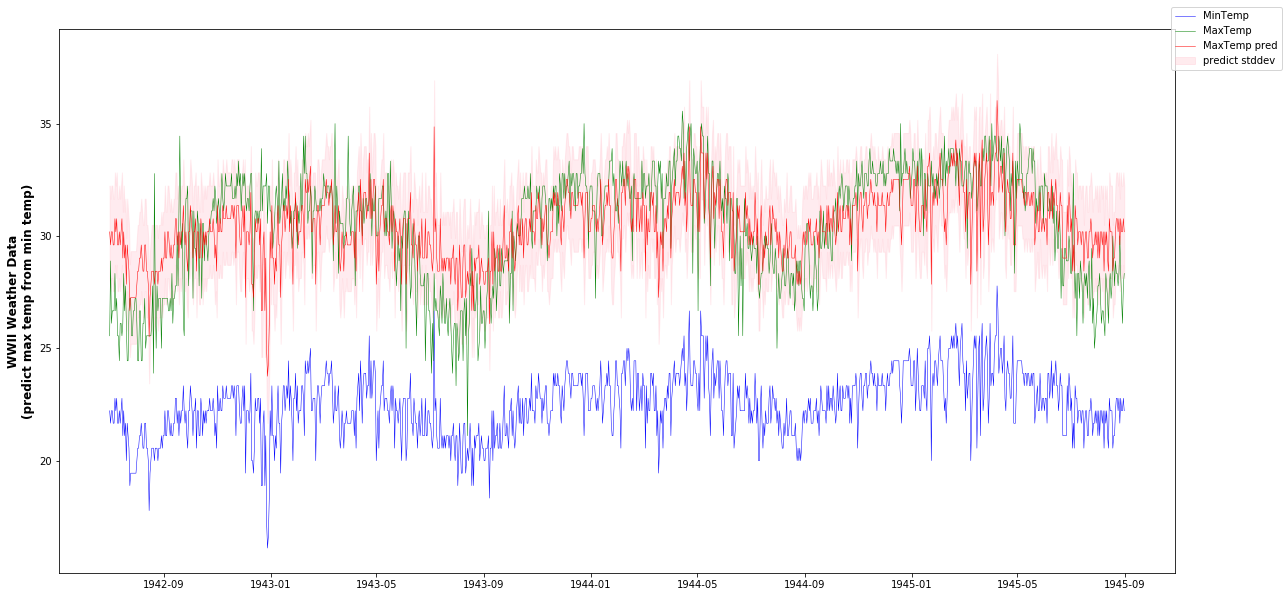

In [10]:
plots = 1

fig, ax = plt.subplots(plots, 1, figsize=(20,10), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i['MinTemp'],linewidth=0.5,color='blue',label='MinTemp')
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i['MaxTemp'],linewidth=0.5,color='green',label='MaxTemp')
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i['predicted_MaxTemp'],linewidth=0.5,color='red',label='MaxTemp pred')
ax[cnt,0].fill_between(df_i.unstack(level=0).index, df_i['predicted_MaxTemp'] - df_i['stddev_MaxTemp'],
                df_i['predicted_MaxTemp'] + df_i['stddev_MaxTemp'], color="pink", alpha=0.3, label="predict stddev")
ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt,0].set_ylabel('WWII Weather Data\n(predict max temp from min temp)',fontsize=12,weight="bold")
cnt = 1

In [11]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = BayesRidgeRegressorExt(['MinTemp'], ['MaxTemp'], degree=3)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)


df_i.describe()

2021-04-22T19:47:23.831 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-04-22T19:47:23.831 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-04-22T19:47:23.832 DEBUG iotfunctions.util.__init__ Starting trace
2021-04-22T19:47:23.832 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_BayesRidgeRegressorExt_20210422174723
2021-04-22T19:47:23.833 DEBUG iotfunctions.util.__init__ auto_save None
2021-04-22T19:47:23.833 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-04-22T19:47:23.835 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-04-22T19:47:23.835 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_BAYESRIDGEREGRESSOREXT
Functions:
Granularities:
No schedules metadata
2021-04-22T19:47:2

/home/markus/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,MaxTemp,MinTemp,MeanTemp,predicted_MaxTemp,stddev_MaxTemp
count,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000
mean,30.496975,22.520407,26.514933,30.474407,2.265710
std,2.509494,1.426508,1.777196,1.585440,0.018516
min,21.111111,16.111111,20.555556,27.630678,2.262511
25%,28.333333,21.666667,25.000000,29.282250,2.262539
50%,31.111111,22.222222,26.666667,30.014023,2.263116
75%,32.222222,23.333333,27.777778,31.533533,2.264256
max,35.555556,27.777778,30.555556,34.113606,2.724967


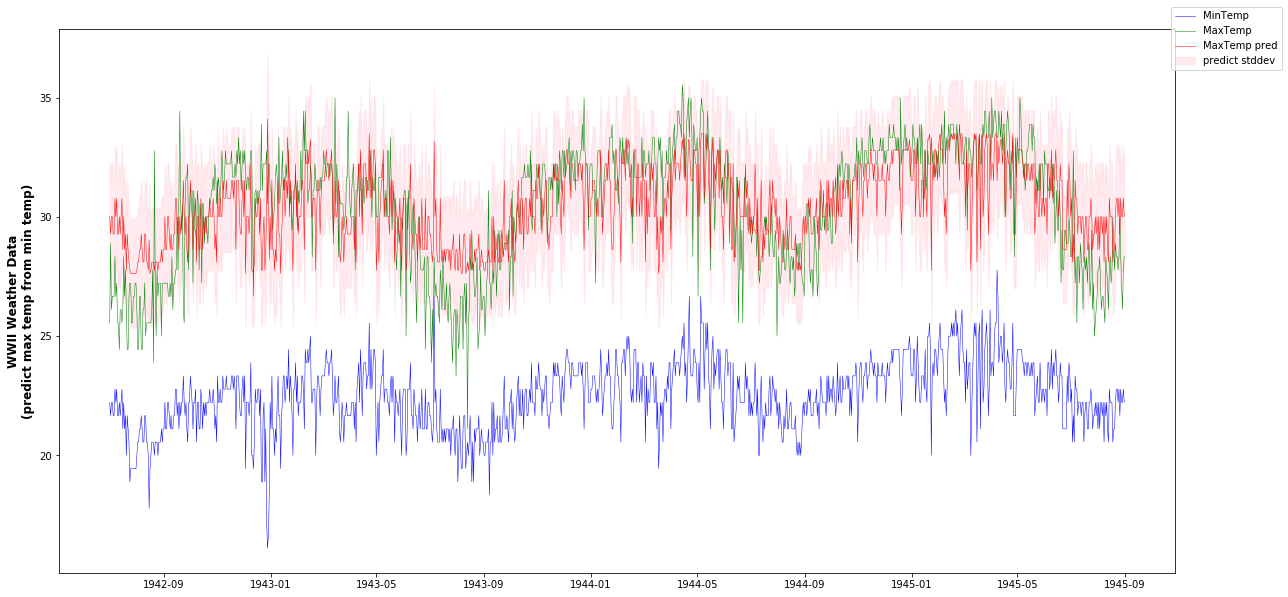

In [12]:
plots = 1

fig, ax = plt.subplots(plots, 1, figsize=(20,10), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i['MinTemp'],linewidth=0.5,color='blue',label='MinTemp')
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i['MaxTemp'],linewidth=0.5,color='green',label='MaxTemp')
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i['predicted_MaxTemp'],linewidth=0.5,color='red',label='MaxTemp pred')
ax[cnt,0].fill_between(df_i.unstack(level=0).index, df_i['predicted_MaxTemp'] - df_i['stddev_MaxTemp'],
                df_i['predicted_MaxTemp'] + df_i['stddev_MaxTemp'], color="pink", alpha=0.3, label="predict stddev")
ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt,0].set_ylabel('WWII Weather Data\n(predict max temp from min temp)',fontsize=12,weight="bold")
cnt = 1